In [158]:
import json
import importlib
import os
import sys
import xml
sys.path.insert(1, os.path.join(sys.path[0], '..'))
from src.utils import parse_lipid, parse_p_value, tight_bbox
from src import plots
importlib.reload(plots)

import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from matplotlib.colors import Normalize, TwoSlopeNorm, CenteredNorm
import seaborn as sns
plt.rcParams['svg.fonttype'] = 'none'
plt.rcParams['pdf.use14corefonts'] = True
plt.rcParams['axes.unicode_minus'] = False  # https://stackoverflow.com/questions/43102564/matplotlib-negative-numbers-on-tick-labels-displayed-as-boxes
plt.style.use('seaborn-ticks')  # 'seaborn-ticks', 'seaborn-white', 'seaborn'
# sns.set_style('white')

from sklearn.preprocessing import StandardScaler
import networkx as nx

In [2]:
colors = json.load(open(r'..\data\metadata\color_schemes.json'))
colors['Non-fasted'] = colors['RBG']
colors['Fasted'] = colors['FBG']
compound_superclasses = json.load(open('../data/metadata/compound_superclasses.json', 'r'))
    
data = pd.read_csv(r'../data/processed/combined_metabolites_data_with_model_params.csv').set_index('i')
data_cols = data.filter(regex='_FBG|_RBG').columns
fbg_cols = data.filter(regex='_FBG').columns
rbg_cols = data.filter(regex='_RBG').columns

ap = pd.read_excel(r'..\data\metadata\animal_phenotypes.xlsx', index_col=0)
fg = pd.read_csv(r'..\data\metadata\combined_metab_lipid_file_grouping.csv', index_col=0)

In [3]:
data['signif_interaction'] = data['qval_sampling:ogtt'] < 0.05
data['signif_sampling'] = data['qval_sampling'] < 0.05
gb_means = (data
            .loc[:, data_cols]
            .groupby(fg['bg_type'], axis=1)
            .mean()
           )

data['fasted_mean'] = gb_means['FBG']
data['fed_mean'] = gb_means['RBG']
data['Log2 Fold Change'] = data['fed_mean'] - data['fasted_mean']

data['Fed - Fasted slope'] = data['coef_fed'] - data['coef_fasted']
data['signif_sampling'] = data['qval_sampling'] < 0.05
data['signif_interact'] = data['qval_sampling:ogtt'] < 0.05
data['log_qval_sampling'] = -np.log10(data['qval_sampling'])
data['log_qval_ogtt'] = -np.log10(data['qval_ogtt'])
data['log_qval_sampling:ogtt'] = -np.log10(data['qval_sampling:ogtt'])
data['is_id'] = data['superclass'] != 'Unidentified'

# The polar metabolomics figure might be improved with some enrichment/network analysis
## Generate data table for Metaboanalyst and draw figures

## Enrichment node:
1. can use Lipids or Metabolites in Concentration table
1. Can do 2-category categorical or a continuous regression group

## Pathway node:
1. Compound list or Concentration table 
1. 2-category or continuous regression group

## Joint-pathway node:
1. Only usable with metabolites & genomic or transcriptomic data

## Network node:
1. Concentration table with Metabolites 
1. Multinomial categorical Groups

In [99]:
df = (data
    .loc[(data['ID'] != 'Unidentified')]
    .set_index('ID')
    .loc[:, data_cols])
df = 2**df
df.rename({'4-Hydroxybutyric acid (GHB)': '4-Hydroxybutyric acid'}, inplace=True)
metabs = df.loc[df.index.isin(data.loc[data['Type'] == 'metabolite', 'ID'])].T
lipids = df.loc[df.index.isin(data.loc[data['Type'] == 'lipid', 'ID'])].T
metabs.insert(0, 'Groups', None)
lipids.insert(0, 'Groups', None)

## Create list of metabolites we detect and are found in hmdb as a reference metabolome (AKA background database)

In [100]:
metabs = metabs.drop([
    'Pentose sugar', 
    'Hexose sugar',
    'Anhydrohexose',
    'N-Methyl-2-pyrrolidone',
    'Methylaminopyrimidine',
    '8-Hydroxyquinoline',
    '5,5-Dimethylhydantoin',
    '2-Mercaptoethanol',
       ], axis=1)
metabs.rename({
    'Ethyl-beta-D-glucuronide': 'Ethyl glucuronide',
    'Ascorbic acid 2-sulfate': 'Ascorbic acid',
    'Indole-3-acrylic acid': 'Indoleacrylic acid',
    'N3,N4-Dimethyl-L-arginine': 'Asymmetric dimethylarginine',
    'N-Isovalerylglycine': 'Isovalerylglycine',
    'Methylhistidine': '1-Methylhistidine',
}, axis=1, inplace=True)
metabs.columns

(metabs
 .columns[1:]
 .to_frame()
 .to_clipboard('../data/metaboanalyst/metabolites_detected.csv', index=False, header=False, sep='\n'))

# Generate csv files for each analysis node

## Enrichment node 

In [114]:
df = metabs.copy()
df['Groups'] = df.index.map(fg['bg_type'])
df.to_csv('../data/metaboanalyst/enrichment/input_enr_sampling_metabs.csv')

df = lipids.copy()
df['Groups'] = df.index.map(fg['bg_type'])
df.to_csv('../data/metaboanalyst/enrichment/input_enr_sampling_lipids.csv')

df = metabs.copy()
df['Groups'] = df.index.map(fg['ogtt'])
df.to_csv('../data/metaboanalyst/enrichment/input_enr_ogtt_metabs.csv')

df = metabs.copy()
df['Groups'] = df.index.map(fg['ogtt'])
df = df.loc[fg['bg_type'] == 'RBG']
df.to_csv('../data/metaboanalyst/enrichment/input_enr_ogtt_metabs_fedonly.csv')

df = metabs.copy()
df['Groups'] = df.index.map(fg['ogtt'])
df = df.loc[fg['bg_type'] == 'FBG']
df.to_csv('../data/metaboanalyst/enrichment/input_enr_ogtt_metabs_fastedonly.csv')

df = lipids.copy()
df['Groups'] = df.index.map(fg['ogtt'])
df = df.loc[fg['bg_type'] == 'RBG']
df.to_csv('../data/metaboanalyst/enrichment/input_enr_ogtt_lipids.csv')

df = lipids.copy()
df['Groups'] = df.index.map(fg['ogtt'])
df = df.loc[fg['bg_type'] == 'RBG']
df.to_csv('../data/metaboanalyst/enrichment/input_enr_ogtt_lipids_fedonly.csv')

df = lipids.copy()
df['Groups'] = df.index.map(fg['ogtt'])
df = df.loc[fg['bg_type'] == 'FBG']
df.to_csv('../data/metaboanalyst/enrichment/input_enr_ogtt_lipids_fastedonly.csv')

## Pathway node

In [102]:
df = metabs.copy()
df['Groups'] = df.index.map(fg['bg_type'])
df.to_csv('../data/metaboanalyst/pathway/input_pathway_sampling_metabs.csv')

df = metabs.copy()
df['Groups'] = df.index.map(fg['ogtt'])
df.to_csv('../data/metaboanalyst/pathway/input_pathway_ogtt_metabs.csv')

## Network node

In [103]:
df = metabs.copy()
df = df.loc[fg['bg_type'] == 'RBG']
df['Groups'] = df.index.map(fg['animal'])
df.to_csv('../data/metaboanalyst/network/input_network_fedonly_animalgroups_metabs.csv')

# The outputs from enrichment, pathway and network nodes are quite sparsely populated with our metabolite IDs in the sets (with few exceptions)
# However the results suggest pathways that make sense, so write down the metabolite sets manually 
## Metaboanalyst is clunky because it doesn't save results online, closes your session after 10 minutes, and has scattered organization system for raw file downloads

# After going through Enrichment and Pathway Nodes with the (1) fed-only OGTT-grouped data and (2) the fasted vs. fed-grouped data, I only found 5 KEGG pathway nodes with decent # metabolites found, and 1 Blood-based disease signature pathway 
# Network node only returned a reasonable result using Debiased Sparse Partial Correlation (DSPC) network on the fed-only OGTT-grouped data
## Using network node on fasted-vs-fed data opened up the other 5 network possibilities, but only 1 worked (KEGG Global metabolic network) and it was so big it was hard to get anything interesting out of it 
## These metabolite sets can be named and their metabolite components can be plotted in a connection graph based on the DSPC network graph file I downloaded at `~/data/metaboanalyst/network/.graphml` file

In [182]:
metab_sets = {
    'KEGG_pathway': 
    {
    'Glycine, serine and threonine metabolism': ['Choline', 'Betaine', 'Threonine', 'Glyceric acid', 'Creatine'],
    'Valine, leucine and isoleucine biosynthesis': ['Threonine', 'Leucine', 'Isoleucine'],
    'Glycerophospholipid metabolism': ['Choline', 'Glycerophosphocholine'],
    'Arginine and proline metabolism': ['Arginine', 'Creatine', 'Proline', 
                                        'Glutamic acid', 'Ornithine', '4-Guanidinobutanoic acid'],
    'Aminoacyl-tRNA biosynthesis': ['Asparagine', 'Histidine', 'Phenylalanine', 'Arginine', 'Glutamine',
                                    'Alanine', 'Isoleucine', 'Leucine', 'Threonine', 
                                    'Tryptophan', 'Tyrosine', 'Proline', 'Glutamic acid',] 
    },
    'Blood_disease_signature': 
    {'DIABETES MELLITUS (MODY), NON-INSULIN-DEPENDENT': ['Glucose', 'Trigonelline', '3-Hydroxybutyric acid',
                                                         'Taurine', 'Glutamine', 'Tryptophan', 'Histidine',
                                                         'Isoleucine', 'Leucine', 'Creatinine', 'Creatine']
    }
}

In [179]:
# g = nx.read_graphml('../data/metaboanalyst/network/fed_only_ogtt_groups_graph.graphml')
# list(g)

In [217]:
aa = {
    'Alanine': 'Ala',
    'Arginine': 'Arg',
    'Asparagine': 'Asn',
    'Aspartic acid': 'Asp',
    'Cysteine': 'Cys',
    'Glutamine': 'Gln',
    'Glutamic acid': 'Glu',
    'Glycine': 'Gly',
    'Histidine': 'His',
    'Isoleucine': 'Ile',
    'Leucine': 'Leu',
    'Lysine': 'Lys',
    'Methionine': 'Met',
    'Phenylalanine': 'Phe',
    'Proline': 'Pro',
    'Serine': 'Ser',
    'Threonine': 'Thr',
    'Tryptophan': 'Trp',
    'Tyrosine': 'Tyr',
    'Valine ': 'Val'
}
aa_deriv = ['Taurine', 'Stachydrine', 'Phenylacetyleglycine', 'Ornithine', 
            '1-Methylhistidine', 'N-Acetylornithine', 'Betaine', 'Beta alanine'
           ]

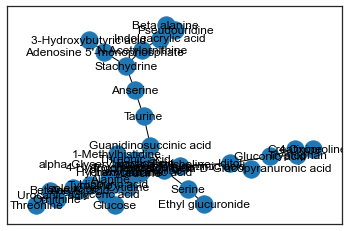

In [197]:
nx.draw_networkx(g)

In [219]:
g = nx.read_graphml('../data/metaboanalyst/network/fed_only_ogtt_groups_graph.graphml', force_multigraph=True)
gnodes = pd.read_csv('../data/metaboanalyst/network/fed_only_ogtt_groups_graph_node_names.csv').set_index('Label')
gnodes['node'] = list(g.nodes)
g = nx.relabel_nodes(g, dict(zip(gnodes['node'], gnodes.index)))

In [220]:
# data.loc[data['molec_class'] == 'Amino acid derivative']

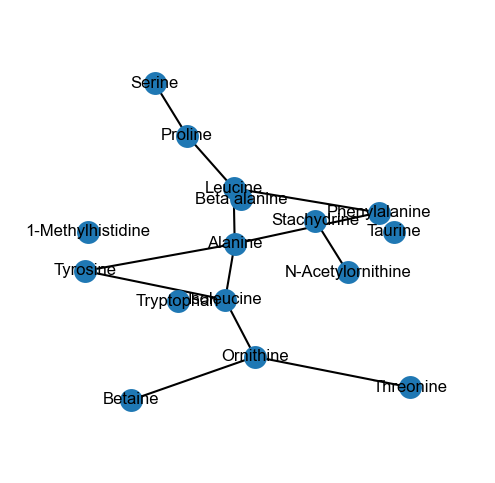

In [223]:
# subg = g.subgraph(metab_sets['KEGG_pathway']['Glycine, serine and threonine metabolism'])
subg = g.subgraph(list(aa.keys()) + aa_deriv)
fig, ax = plt.subplots(figsize=(4,4), dpi=150)
nx.draw_networkx(
    subg, 
#     pos=nx.spring_layout(subg, seed=3), 
    pos=nx.kamada_kawai_layout(subg),
    ax=ax,
    font_size=8, node_size=100,
                 
)

ax.margins(0.15)
sns.despine(bottom=True, left=True)

In [188]:
[x.capitalize() for x in aa]

['Alanine',
 'Arginine',
 'Asparagine',
 'Aspartic acid',
 'Cysteine',
 'Glutamine',
 'Glutamic acid',
 'Glycine',
 'Histidine',
 'Isoleucine',
 'Leucine',
 'Lysine',
 'Methionine',
 'Phenylalanine',
 'Proline',
 'Serine',
 'Threonine',
 'Tryptophan',
 'Tyrosine',
 'Valine']

In [186]:
aa = [
'alanine',
'arginine',
'asparagine',
'aspartic acid',
'cysteine',
'glutamine',
'glutamic acid',
'glycine',
'histidine',
'isoleucine',
'leucine',
'lysine',
'methionine',
'phenylalanine',
'proline',
'serine',
'threonine',
'tryptophan',
'tyrosine',
'valine',
]

In [149]:
nodelist

Index([], dtype='object', name='Label')

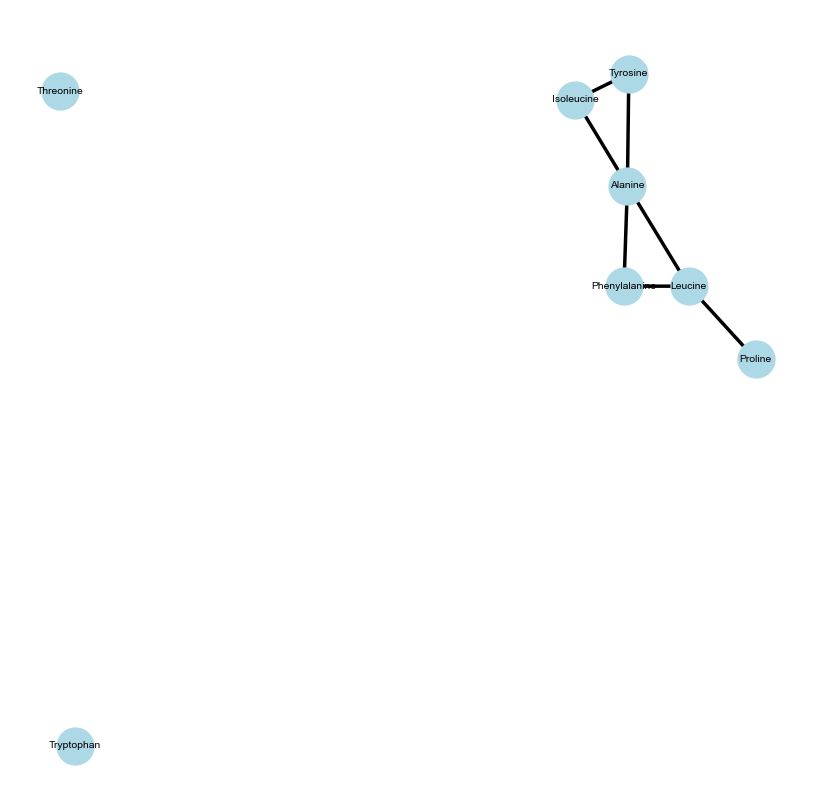

In [150]:
# nodelist = gnodes.loc[gnodes['Degree'] > 6].index
# nodelist = gnodes.loc[gnodes['Betweenness'] > 0].index
nodelist = gnodes.loc[gnodes.index.isin(
    metab_sets['KEGG_pathway'][ 'Aminoacyl-tRNA biosynthesis'])].index
subgraph = g.subgraph(nodelist)

fig, ax = plt.subplots(figsize=(4, 4), dpi=250)
nx.draw_networkx(
    subgraph,
    pos=nx.spring_layout(subgraph),
    font_size=3,
    nodelist=nodelist,
    node_size=100, node_color='lightblue',
)
sns.despine(bottom=True, left=True)

# Older analysis (testing out metaboanalyst results) below

In [104]:
g = nx.read_graphml('../data/processed/metaboanalyst_graph.graphml')

gnodes = pd.read_csv('../data/processed/metaboanalyst_graph_node_table.csv').set_index('Label')
gnodes['node'] = list(g.nodes)
gnodes

g = nx.relabel_nodes(g, dict(zip(gnodes['node'], gnodes.index)))
g.nodes

NodeView(('Alanine', 'Pentose sugar', 'Trigonelline', 'Threonine', 'Ornithine', 'Hydroxycinnamic acid', 'Indole-3-acrylic acid', 'Leucine', 'Isoleucine', 'Proline', 'Quinic acid', 'Acrylic acid', 'Phenylalanine', 'Hippuric acid', 'Hydrocinnamic acid', 'Choline', '4-Hydroxybenzaldehyde', 'Guanidinosuccinic acid', 'Tyrosine', 'Asparagine', 'Glucose', 'Lactic Acid', 'Tryptophan', 'Creatine', 'alpha-Glycerylphosphorylcholine', 'Threonic acid', 'N-Acetylneuraminic acid', 'N-Acetylornithine', 'N-Acetyl-L-aspartic acid', 'Gluconic acid', 'Anhydrohexose', 'Pipecolic acid', 'Nicotinamide 1-oxide', '3-Methylhistidine', 'Stachydrine', 'Ribose', 'Pseudouridine', 'Hexose sugar', 'Nicotinamide', 'Creatinine', 'Phenylacetylglycine', 'Carnitine', 'Histidine', 'Ergothioneine', 'Citramalic acid', 'Betaine', 'Anserine', '5,5-Dimethylhydantoin', '4-Hydroxybutyric acid'))

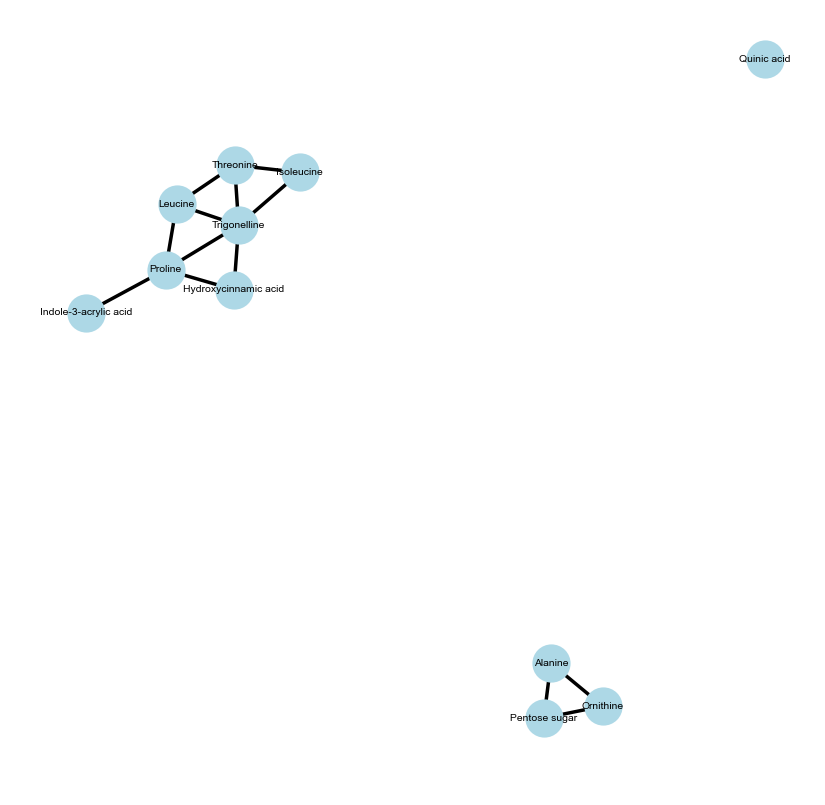

In [120]:
nodelist = gnodes.loc[gnodes['Degree'] > 6].index
# nodelist = gnodes.loc[gnodes['Betweenness'] > 0].index
subgraph = g.subgraph(nodelist)

fig, ax = plt.subplots(figsize=(4, 4), dpi=250)
nx.draw_networkx(
    subgraph,
    pos=nx.spring_layout(subgraph),
    font_size=3,
    nodelist=nodelist,
    node_size=100, node_color='lightblue',
)
sns.despine(bottom=True, left=True)

In [10]:
data.loc[(data['Type'] == 'metabolite') & (data['ID'] != 'Unidentified'), 'ID'].values#.to_clipboard()

array(['Urocanic acid', 'Uridine', 'Uric acid', 'Tyrosine', 'Tryptophan',
       'Trigonelline', 'Indole-3-acrylic acid', 'Threonine',
       'Threonic acid', 'Taurine', 'Stachydrine', 'Serine', 'Ribose',
       'Quinic acid', 'Pseudouridine', 'Proline', 'Pipecolic acid',
       'Phenylalanine', 'Phenylacetylglycine', 'Pentose sugar',
       'Ornithine', 'Nicotinamide 1-oxide', 'Nicotinamide',
       'N6,N6,N6-Trimethyl-L-lysine', 'N3,N4-Dimethyl-L-arginine',
       'N-Methyl-2-pyrrolidone', 'N-Isovalerylglycine',
       'N-Acetylornithine', 'N-Acetylneuraminic acid',
       'N-Acetyl-L-aspartic acid', 'Methylhistidine',
       'Methylaminopyrimidine', 'Leucine', 'Lactic Acid', 'Isoleucine',
       'Hydroxycinnamic acid', 'Hydrocinnamic acid', 'Histidine',
       'Hippuric acid', 'Iditol', 'Hexose sugar',
       'Guanidinosuccinic acid', 'Glyceric acid', 'Glutamine',
       'Glutamic acid', 'Glucose', 'Gluconic acid',
       'Ethyl-beta-D-glucuronide', 'Ergothioneine', 'Cytidine',
    

In [ ]:
fig, axs = plt.subplot_mosaic(
    '''
    .AAABB
    .AAABB
    x.CCCD
    ..CCCE
    ''',
    dpi=150, figsize=(8,8), facecolor='white',
    gridspec_kw=dict(wspace=1.2, hspace=1.1, 
                     width_ratios=[1, 0.1, 4, 4, 4, 7],
                     height_ratios=[1, 1, 1, 1]),
)

axvol = plots.volcano(x='Log2 Fold Change', y='log_qval_sampling', 
                      df=data, metab_type='lipid', ax=axs['A'], legend=True)
axvol.legend(loc=(-1, 0))
axslopes = plots.fasted_fed_slope('lipid', alpha=0.8, ax=axs['B'])
axvol.tick_params(length=3)
axslopes.tick_params(length=3)

ax = make_carbon_unsat_plot('TG', 0.18, ax=axs['C'], cax=axs['x'])
num_tg = ids.loc[ids['molec_class'] == 'TG'].shape[0]
axs['C'].set_title(f'TG  n={num_tg}', fontsize=10, pad=0)
for xy, width, height in [
#     ((45.5, -0.5), 13, 3), ((45.5, 2.5), 15, 3), ((51.3, 5.5), 7.5, 4), 
    ((57.3, 9.5), 9, 9)
]:
    ax.add_patch(patches.Rectangle(xy, width, height, linewidth=1, edgecolor='0.1', facecolor='none'))

for unsat_low, unsat_high, subplot in [
    (0, 99, 'E'), 
#     (0, 2, 'C'), (3, 5, 'D'), (6, 9, 'E'), 
    (10, 99, 'D')
]:
    plot_quant_vs_ogtt(lipid_means(unsat_low, unsat_high), x='ogtt', y='quant', palette=colors, 
                       animal_lines=False, xlabel='OGTT glucose AUC', ylabel='Mean log2 quant.', 
                       scatter_kws={'s': 14, 'edgecolor': '0.2', 'linewidth': 0.25, 'zorder': 10}, 
                       line_kws={'linewidth': 1}, ax=axs[subplot])
fs=9   
axs['B'].set_xlabel('Non-fasted regression slope')
axs['B'].set_ylabel('Fasted regression slope')
axs['D'].legend(loc=(1, 0), handles=axs['D'].get_legend_handles_labels()[0], labels=['Fasted', 'Non-fasted'],
                markerscale=3,)
axs['D'].tick_params(length=3)
axs['D'].set_yticks([19, 21, 23], fontsize=fs)
axs['D'].set_xticks([20000, 40000, 60000], ['20k', '40k', '60k'], fontsize=fs)
axs['D'].set_ylabel('Mean log2 quant.', fontsize=fs)
axs['D'].set_xlabel('OGTT glucose AUC', fontsize=fs)
axs['E'].tick_params(length=3)
axs['E'].set_yticks([21, 23, 25], fontsize=fs)
axs['E'].set_xticks([20000, 40000, 60000], ['20k', '40k', '60k'], fontsize=fs)
axs['E'].set_ylabel('Mean log2 quant.', fontsize=fs)
axs['E'].set_xlabel('OGTT glucose AUC', fontsize=fs)
# handles, labels = axs['B'].get_legend_handles_labels()
# axs['B'].legend(handles=handles, labels=['Fasted', 'Non-fasted'], loc=(-1.4, 0.5), markerscale=2, title='Sampling')
axs['x'].text(s='Fasted\nHigher', x=0.5, y=-0.05, transform=axs['x'].transAxes, ha='center', va='top')
# axs['x'].yaxis.set_label_position('left')

for ax_letter, ax in axs.items():
    if ax_letter == 'x':
        continue
    bb = tight_bbox(ax)
    ax.text(s=ax_letter, x=bb.x0-0.002, y=bb.y1+0.01, fontweight='bold', transform=fig.transFigure)

# plt.savefig(r'..\reports\figures\Figure_TGs\FA_unsat_carbons_mean_regplots.png', dpi=200, bbox_inches='tight', facecolor='white')
# plt.savefig(r'..\reports\figures\Figure_TGs\FA_unsat_carbons_mean_regplots.pdf', dpi=200, bbox_inches='tight', facecolor='white')